In [ ]:
# 1
import numpy as np
import pandas as pd
import regex as re
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import gensim

from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import warnings


In [ ]:
# 2
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# 3
train = pd.read_csv("//content/drive/MyDrive/f22/train_tweet.csv")
test = pd.read_csv("/content/drive/MyDrive/f22/test_tweets.csv")


In [ ]:
# 4
train[train["label"] == 0].head(3)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty


In [ ]:
# 5
train[train['label'] == 1].head(3)


,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!


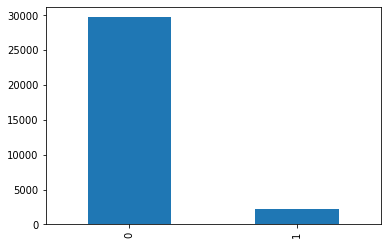

In [ ]:
# 6
train['label'].value_counts().plot.bar()


In [ ]:
# 7
train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()


In [ ]:
# 8
train.groupby('label').describe()


id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
0      29720.0  15974.454441  9223.783469   1.0  7981.75  15971.5  23965.25   
1       2242.0  16074.896075  9267.955758  14.0  8075.25  16095.0  24022.00   

                    len                                                        
           max    count       mean        std   min   25%   50%    75%    max  
label                                                                          
0      31962.0  29720.0  84.328634  29.566484  11.0  62.0  88.0  107.0  274.0  
1      31961.0   2242.0  90.187779  27.375502  12.0  69.0  96.0  111.0  152.0

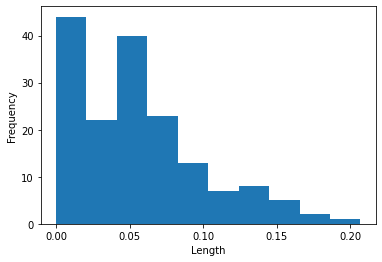

In [ ]:
# 9
train.groupby('len').mean()['label'].plot.hist()
plt.ylabel('Frequency')
plt.xlabel('Length')
plt.show()


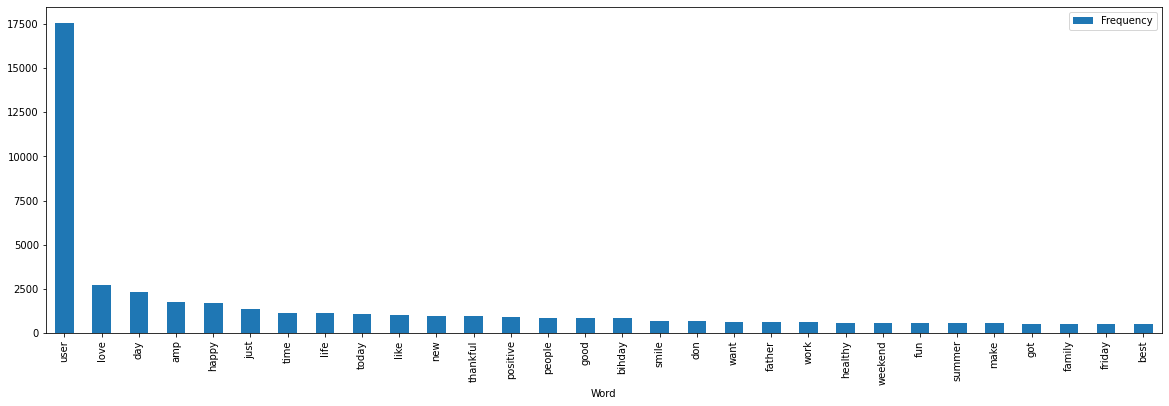

In [ ]:
# 10
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['Word', 'Frequency'])
frequency.head(20).plot(x='Word', y='Frequency', kind='bar', figsize = (20,6))


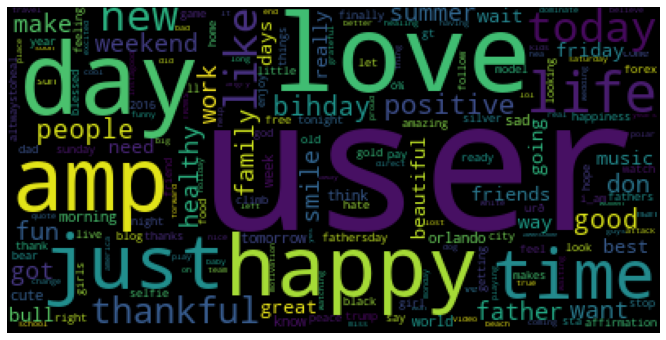

In [ ]:
# 11
wc = WordCloud().generate_from_frequencies(dict(words_freq))
plt.figure(figsize=(20,6))
plt.axis('off')
plt.imshow(wc)


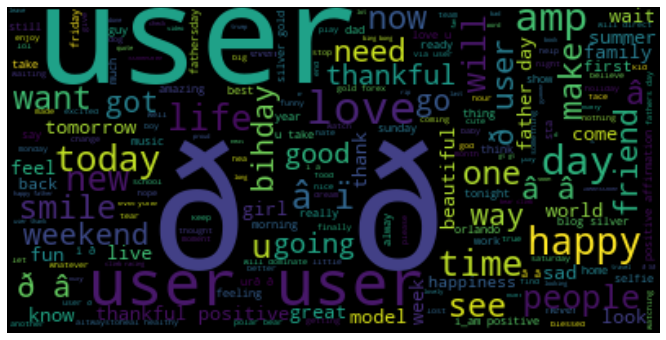

In [ ]:
# 12
positive_words =' '.join([text for text in train['tweet'][train['label'] == 0]])
wc = WordCloud().generate(positive_words)
plt.figure(figsize=(20, 6))
plt.axis('off')
plt.imshow(wc, interpolation="bilinear")


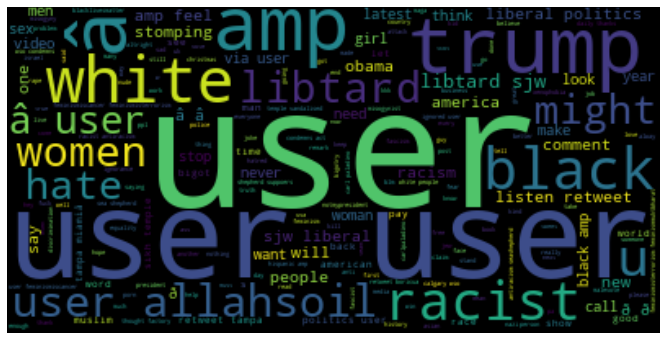

In [ ]:
# 13
negative_words =' '.join([text for text in train['tweet'][train['label'] == 1]])
wordcloud = WordCloud().generate(negative_words)
plt.figure(figsize=(20, 6))
plt.axis('off')
plt.imshow(wordcloud, interpolation="bilinear")


In [ ]:
# 14
def hashtag_extract(x):
    hashtags = []
    for i in x:
        curr_hashtags = re.findall(r"#(\w+)", i)
        hashtags.append(curr_hashtags)
    return hashtags
    

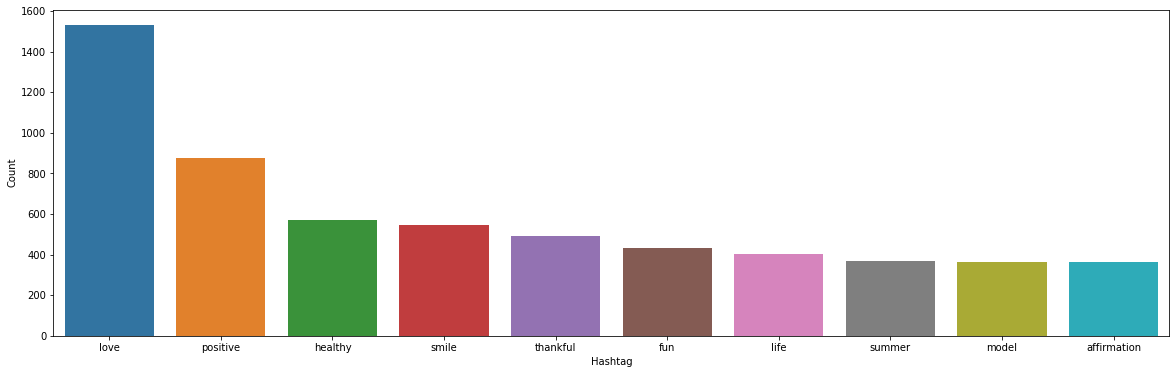

In [ ]:
# 15 
ht_positive = hashtag_extract(train['tweet'][train['label'] == 0])
ht_positive = sum(ht_positive,[])

a = nltk.FreqDist(ht_positive)
b = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())}) 
  
info = b.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=info, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()


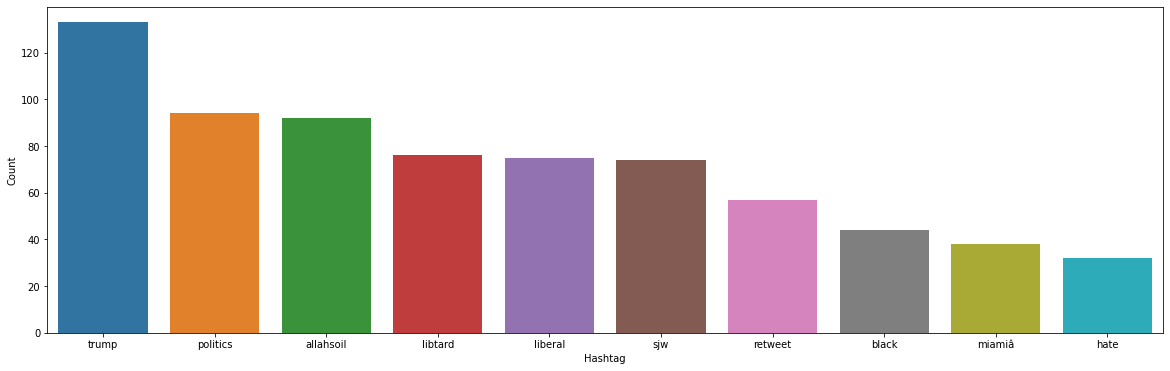

In [ ]:
# 16
ht_negative = hashtag_extract(train['tweet'][train['label'] == 1])
ht_negative = sum(ht_negative,[])

a = nltk.FreqDist(ht_negative)
b = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
   
info = b.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(20,6))
ax = sns.barplot(data=info, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [ ]:
# 17
tokenized_tweet = train['tweet'].apply(lambda x: x.split()) 

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, 
            window=5,
            min_count=2,
            sg = 1,
            hs = 0,
            negative = 10,
            workers= 2,
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['tweet']), epochs=20)

(6109138, 8411580)

In [ ]:
# 18
model_w2v.wv.most_similar(positive = "computer")


[('#life.', 0.7062926292419434),
 ('equipment', 0.6704912781715393),
 ('#advice', 0.6462880969047546),
 ('failure.', 0.6348996758460999),
 ('gets...', 0.6317304372787476),
 ('beautyâ\x80¦', 0.6317099332809448),
 ('accompany', 0.629393994808197),
 ('keys', 0.6281991600990295),
 ('#engine', 0.6278864741325378),
 ('raging', 0.624492883682251)]

In [ ]:
# 19
model_w2v.wv.most_similar(positive = "food")


[('benefits!', 0.5731759071350098),
 ('integral', 0.5715633630752563),
 ('blading', 0.5665189623832703),
 ('#raw', 0.5657171010971069),
 ('dollars', 0.5645654797554016),
 ('diet', 0.5583655834197998),
 ('cooked', 0.5560532808303833),
 ('lawyer', 0.5478268265724182),
 ('frenzy', 0.5445280075073242),
 ('quiet', 0.5343256592750549)]

In [ ]:
# 20
model_w2v.wv.most_similar(negative = "computer")


[('#apple', -0.009680822491645813),
 ('#fitness', -0.020493853837251663),
 ('#cycling', -0.03174497187137604),
 ('#weightloss', -0.037078965455293655),
 ('#wednesdaywisdom', -0.04351806640625),
 ('#fit', -0.04788774996995926),
 ('#gym', -0.04999523609876633),
 ('#fundraising', -0.05142752081155777),
 ('#hype', -0.05345311015844345),
 ('#australia', -0.06279037147760391)]

In [ ]:
# 21
model_w2v.wv.most_similar(negative = "food")


[('ð\x9f\x98\x81', 0.01652703247964382),
 ('#wwdc2016', 0.014584813266992569),
 ('#apple', 0.008249014616012573),
 ('#yay', 0.0009962376207113266),
 ('#cycling', -0.0011313557624816895),
 ('#ready', -0.010350123047828674),
 ('#wednesdaywisdom', -0.013593560084700584),
 ('#hype', -0.01716195046901703),
 ('#wwdc', -0.026302345097064972),
 ('â\x80¦', -0.030231481418013573)]

In [ ]:
# 22
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(tokenized_tweet)
labeled_tweets[:2]


<ipython-input-23-4ca9379e9958>:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  output.append(LabeledSentence(s, ["tweet_" + str(i)]))


[LabeledSentence(words=['@user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction.', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['@user', '@user', 'thanks', 'for', '#lyft', 'credit', 'i', "can't", 'use', 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'in', 'pdx.', '#disapointed', '#getthanked'], tags=['tweet_1'])]

In [ ]:
# 23
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# 24
train_corpus = []

for i in range(31962):
  review = re.sub('[^a-zA-Z]', ' ', train['tweet'][i])
  review = review.lower()
  review = review.split()
  ps = PorterStemmer()
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  review = ' '.join(review)
  train_corpus.append(review)

In [ ]:
# 25
test_corpus = []

for i in range(17197):
  review = re.sub('[^a-zA-Z]', ' ', test['tweet'][i])
  review = review.lower()
  review = review.split()
  ps = PorterStemmer()
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  review = ' '.join(review)
  test_corpus.append(review)
  

In [ ]:
# 26
cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(train_corpus).toarray()
y = train.iloc[:, 1]
x_test = cv.fit_transform(test_corpus).toarray()
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)


In [ ]:
# 27
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))
print("F1 score :", f1_score(y_valid, y_pred))


Training Accuracy : 0.9991656585040257
Validation Accuracy : 0.9529470654486297
F1 score : 0.6155419222903886


In [ ]:
# 28
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))
print("f1 score :", f1_score(y_valid, y_pred))


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy : 0.9851487213716574
Validation Accuracy : 0.9416843949443123
f1 score : 0.5933682373472949


In [ ]:
# 29
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))
print("f1 score :", f1_score(y_valid, y_pred))


Training Accuracy : 0.9991656585040257
Validation Accuracy : 0.9309222875735202
f1 score : 0.5306122448979591


In [ ]:
# 30
model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))
print("f1 score :", f1_score(y_valid, y_pred))


Training Accuracy : 0.978181969880272
Validation Accuracy : 0.9521962207483419
f1 score : 0.4986876640419947
